## E16 - 인공지능으로 새로운 패션 만들기

판별 모델: 입력된 데이터셋을 특정 기준에 따라 분류하는 또는 특정 값을 맞추는 모델   
생성 모델: 학습한 데이터셋과 비슷하면서 기존에는 없던 새로운 데이터셋을 생성하는 모델   

이미지생성 모델   
Pix2Pix: 이미지와 실제 이미지가 쌍으로 이루는 데이터셋을 학습하여 이미지를 입력받으면 사진 같은 이미지를 출력한다.   
https://arxiv.org/pdf/1611.07004.pdf   
CycleGAN: 이미지와 실사을 양방향으로 변환이 가능하다. 데이터가 쌍(입력, 출력)으로 있을 필요가 없다. 사진에 고유의 스타일을 입힐 수 있다.   
Neural Style Transfer: 스타일을 변환시킬 수 있다. base image에서 content와 style image에서 style를 추출해서 합친다.   


In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

# 라벨이 필요없다.
(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 이미지를 [-1, 1]로 정규화합니다.

train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
# 채널 추가하기 (흑백이므로 1 추가)

train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

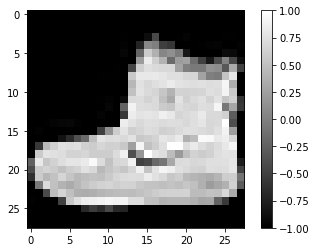

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

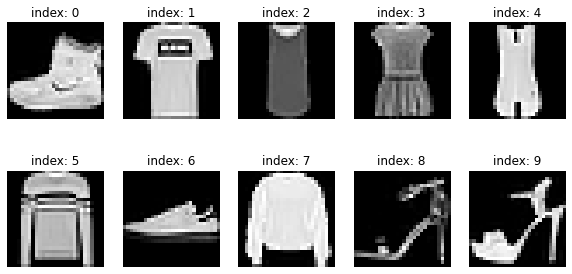

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

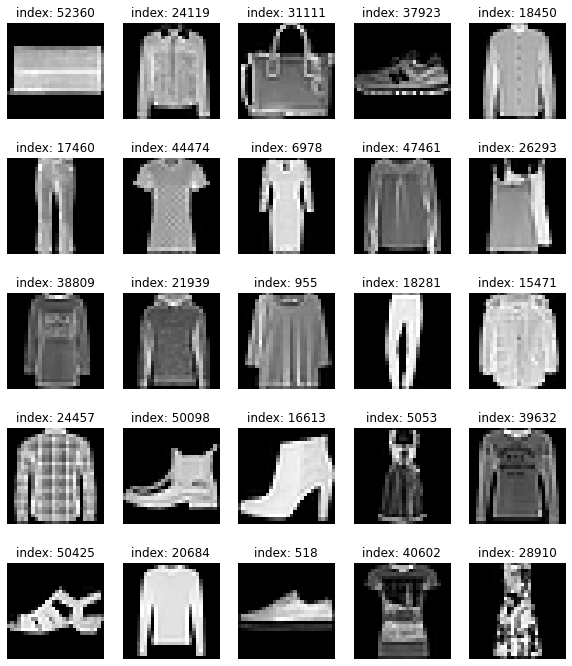

In [9]:
plt.figure(figsize=(10, 12))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    i = np.random.randint(60000)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# from_tensor_slices(): 리스트, numpy, tf의 텐서 자료형에서 데이터셋을 만드는 함수
# train_x(numpy ndarray형)
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# 가장 간단한 이미지 생성 모델, GAN(2014년 처음 발표)
# https://openai.com/blog/generative-models/
# 1년 반이 지난 뒤 DCGAN이 발표, 고화질의 이미지 생성
# 현재 DCGAN를 발전시킨 모델이 대부분
# https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
# tensorflow 2.0 DCGAN 튜토리얼

# 생성 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

# 세 번의 conv2dtranspose를 거치면서 이미지가 커진다. (7,7,256 -> 14,14,64 -> 28,28,1)
# https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11
# What is Transposed Convolutional Layer?
# layer에 batchnormalization()은 가중치가 폭발하지 않도록 정규화 시켜준다.
# 마지막 층의 활성화 함수는 tanh를 사용

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
# tf.random.normal(): 가우시안 분포에서 뽑아낸 랜덤 벡터, 노이즈 벡터
noise = tf.random.normal([1, 100])

In [15]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.4621367e+00,  6.7337334e-01, -8.6517638e-01,  1.5639263e+00,
        -6.1621881e-01, -6.2792444e-01, -1.3603519e+00, -1.0633709e+00,
        -1.8002164e-01, -1.7131877e-01,  4.9259576e-01,  7.9508416e-02,
        -8.4104347e-01, -5.8048987e-01, -6.8085241e-01, -1.9134114e+00,
        -9.9774760e-01,  6.0179770e-01,  6.6043723e-01, -1.2321100e-01,
         5.3420228e-01, -7.9928167e-02,  1.7533818e+00,  3.0780801e-01,
         9.1643310e-01, -8.3391190e-01, -1.7419692e+00,  1.3243605e+00,
        -9.4122756e-01,  1.6834816e+00, -4.8751169e-01,  6.8006420e-01,
         1.2553706e+00, -3.9433128e-01,  4.6552077e-01, -5.8896303e-01,
         1.8941710e+00, -7.1208405e-01,  2.3817651e-01, -1.5158381e-01,
        -2.5124192e-01,  6.6248679e-01, -5.1126033e-01, -1.1760632e+00,
        -4.3707567e-01,  1.5664725e+00,  4.1044513e-03, -2.0268756e-01,
        -1.1718136e-01,  2.8077033e-01,  6.6326421e-01, -2.1748786e+00,
        -1.116

In [16]:
# tf2.0에서는 레이어와 모델에 call메소드를 구현, 모델을 호출을 간단히 출력이미지 생성
# 학습하지 않으므로 training은 false로 설정 (batch normalization레이어는 훈련시기와 추론시기의 행동이 다르다?)
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

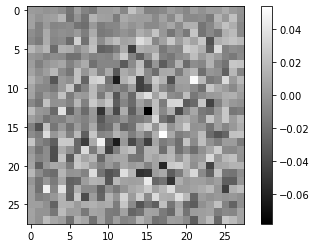

In [17]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [18]:
# 판별 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

# conv2D layer를 통해 이미지를 줄인다. (28,28,2 -> 14,14,64 -> 7,7,128 -> flatten -> 1, 6272)

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00017227]], dtype=float32)>

In [21]:
# GAN은 교차 엔트로피(cross entropy)를 손실 함수로 사용
# 판별자는 한 개의 이미지가 가짜인지 진짜인지 구분하는 분류 문제에 해당, binary cross entropy
# 생성자는 fake image의 판별값이 1에 가까워지도록 발전
# 판별자는 real image의 판별값은 1, fake image의 판별값은 0에 가까워지도록 발전

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# binarycrossentropy는 0~1의 값을 입력받는다. 그래서 from_logits는 True로 설정

In [22]:
# fake_output은 fake image에 의해 판별되는 값
# real_output은 real image에 의해 판별되는 값
# tf.ones_like()와 tf.zeros.like()함수를 이용하여 값을 0,1에 대해 비교한다.
# 위 함수는 특정 벡터와 동일한 크기로 값은 0 또는 1로 채워진 벡터를 생성한다.

vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [23]:
# 생성자의 손실함수
# fake_output이 1에 가까울수록 cross_entropy는 작아진다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
# 판별자의 손실함수
# real_output은 1, fake_output은 0에 가까울수록 cross_entropy는 작아진다.

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
# 판별자의 real_output, fake_output의 accuracy는 GAN 학습의 중요한 요소이다.
# real_output의 정확도가 1.0에 가까울수록 잘 판별하지 못한다는 뜻이다.
# 생성자의 fake_output과 판별자의 real_output이 차이가 많이 나서?
# 학습 초반에서 1.0이 나오다가 서서히 0.5에 가까워질수록 좋다.

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# ex)real_output=tf.Tensor([0.2,0.4,0.7,0.9])
# real_output의 각 원소가 0.5이상인지 true, false로 구별
# tf.math.greater_equal(real_output, tf.constant([0.5])) ---(1)
# tf.Tensor([False,False,True,True])
# 위 결과 true면 1, false면 0으로 변환
# tf.cast((1), tf.float32) ---(2)
# tf.Tensor([0.0,0.0,1.0,1.0])
# 위 결과를 평균내어 정확도 계산
# tf.reduce_mean((2))

In [26]:
# 최적화 함수는 Adam 최적화 기법를 사용
# 생성자와 판별자, 두 개의 모델이 사용되므로 최적화 함수도 각각 정의

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
# 학습 진행 상황을 알아보기 위해 16개의 노이즈
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### decorator

In [28]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [29]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

### 훈련코드설계

In [30]:
# 미니배치 당 진행할 train_step 함수 정의

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

# (1) real image 역할의 이미지를 한 세트 입력받는다.
# (2) fake image를 생성하기 위해 noise을 batch_size만큼 생성
# (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동미분으로 계산하기 위해 
# (4) generator로 fake_image 생성
# (5) discriminator로 image와 fake_image의 값을 계산하기
# (6) loss값 계산하기
# (7) accuracy 계산하기
# (8) gradient 계산하기, gen_tape, disc_tape
# (9) 가중치 업데이트 진행
# (10) 리턴

In [31]:
# 학습 진행 상황을 알아보기 위해 이미지 확인

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()
    
# 이미지 저장할 때 폴더가 없으면 try except구문을 이용하여 os.mkdir('./generated_sample')으로 폴더 생성

In [32]:
# loss, accuracy를 시각화하기
# gen_loss, disc_loss, real_accuray, fake_accuracy를 dict로 저장해서, epoch마다 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [33]:
# tf.train.Checkpoint()이용하여 모델에 대한 저장 및 버전 관리
# 생성자와 구분자가 학습한 모델의 가중치 저장

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
# 한 번의 학습단계(train_step)
# 샘플 이미지를 생성하고 저정하는 단계(generate_and_save_images())
# 학습과정을 시각화하는 단계(draw_train_history())
# 모델 저장하는 단계(checkpoint)
# 위 과정을 통합하는 코드

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [35]:
save_every = 5
EPOCHS = 50

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [45]:
# 학습과정을 움짤로 시각화하기
# gif파일은 imageio라이브러리를 이용

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel0042 aiffel0042 1343651 10월  5 16:59 /home/aiffel0042/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
